"developed by : aipythoner@gmail.com"

[Kaggle-Link To Dataset](https://www.kaggle.com/mmoreaux/environmental-sound-classification-50)

__* Code tested on kaggle Notebook with GPU *__  
*I'm a tensorflow(keras) user and try to learn how fastai library work, but prefer to do it on realworld datasets*

In [1]:
from fastai import *
from fastai.vision import *

In [2]:
import matplotlib.pyplot as plt
from matplotlib.backend_bases import RendererBase
from scipy import signal
from scipy.io import wavfile
from scipy.fftpack import fft
import pandas as pd

import os, glob, numpy as np
from PIL import Image

In [3]:
audio_path = '../input/environmental-sound-classification-50/audio/audio/44100/'
label_csv = '../input/environmental-sound-classification-50/esc50.csv'

In [4]:
waves = glob.glob(audio_path+'*.wav');
print(len(waves))

2000


In [5]:
df = pd.read_csv(label_csv, usecols=['filename', 'target', 'category'], index_col=['filename'])
df.head()

,target,category
filename,,
1-100032-A-0.wav,0,dog
1-100038-A-14.wav,14,chirping_birds
1-100210-A-36.wav,36,vacuum_cleaner
1-100210-B-36.wav,36,vacuum_cleaner
1-101296-A-19.wav,19,thunderstorm


In [6]:
def create_dir(dirname):
    if os.path.exists(dirname):
        pass
    else:
        os.makedirs(dirname)

In [7]:
def save_spectogram(file, output, figsize=(4,4)):
    """
    convert wav to spectrogram and save the result as jpg
    file: path to a .wav file
    output: path to save .jpg result
    figsize=(4,4) : specify output image size=288x288
    """
    freq, sound = wavfile.read(file)
    freq, time, specto = signal.spectrogram(sound)
    specto = 10*np.log(specto.astype(np.float32))
    
    # make images 288x288, no frame on output
    fig = plt.figure(figsize=figsize, frameon=False) 
    ax = plt.Axes(fig, [0.,0.,1.,1.])
    ax.set_axis_off() #we don't need axis on output images
    fig.add_axes(ax)
    ax.pcolormesh(time/100, freq, specto)
    fig.savefig(output, dpi=100)
    plt.close()

In [8]:
import matplotlib
matplotlib.use('Agg') #stop display output in ipython

for item in waves:
    name=item.split('/')[-1]
#     print(name)
    dirname='./prep/' + df.loc[name].category
    create_dir(dirname)
    out_file = dirname+ '/' + name.split('.wav')[0] + '.jpg'
    save_spectogram(item, out_file)
    
print('done')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


done


In [9]:
tfms = get_transforms(do_flip=False, max_rotate=0.)
data = ImageDataBunch.from_folder('./prep/', valid_pct=0.1, ds_tfms=tfms, size=224)
data.normalize()

ImageDataBunch;

Train: LabelList (1800 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
laughing,laughing,laughing,laughing,laughing
Path: prep;

Valid: LabelList (200 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
rooster,keyboard_typing,toilet_flush,drinking_sipping,hand_saw
Path: prep;

Test: None

In [10]:
#from Settings(on the right panel) Turn on Internet to download resnet50 pretrained
learner_model = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [11]:
learner_model.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,4.295577,2.618484,0.670000,00:21
1,3.287687,1.918797,0.535000,00:17
2,2.649607,1.600827,0.475000,00:18
3,2.244384,1.568793,0.470000,00:17


In [13]:
learner_model.unfreeze()
learner_model.fit_one_cycle(4, max_lr=slice(1e-5, 1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,2.131020,2.467929,0.550000,00:19
1,2.153542,2.109388,0.435000,00:18
2,1.735160,1.183957,0.345000,00:19
3,1.301197,0.948590,0.270000,00:19


In [22]:
interp = ClassificationInterpretation.from_learner(learner_model)
%matplotlib inline

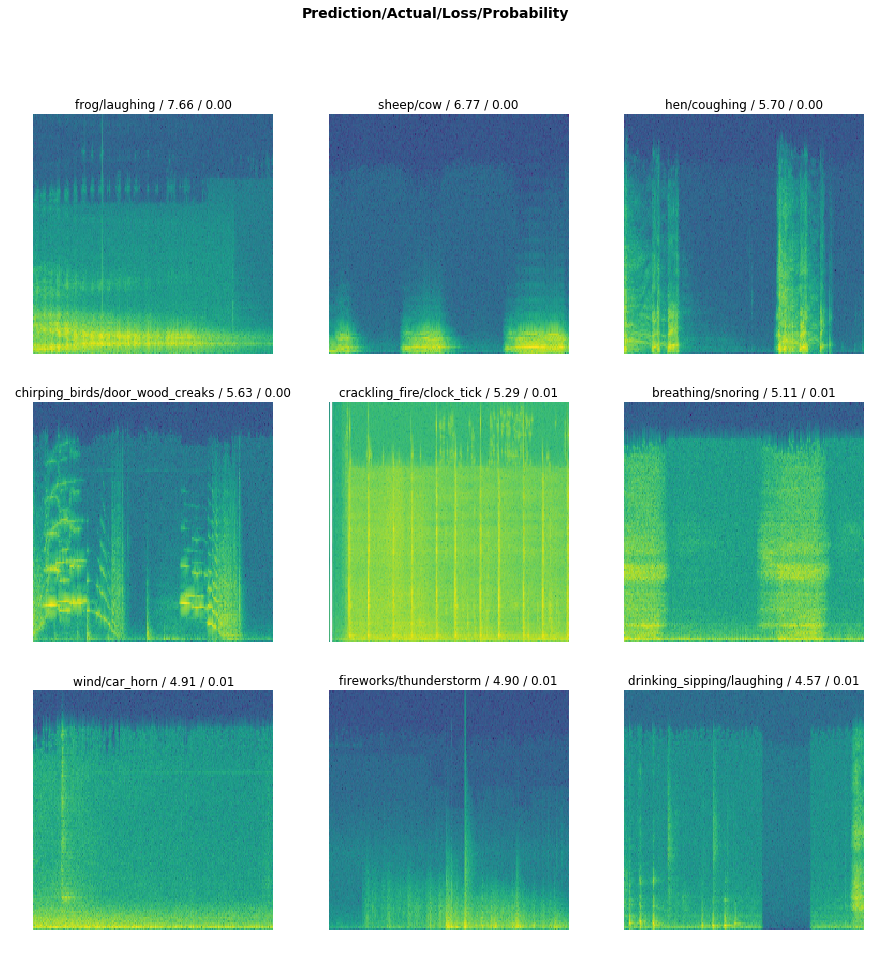

In [23]:
interp.plot_top_losses(9, figsize=(15,15))

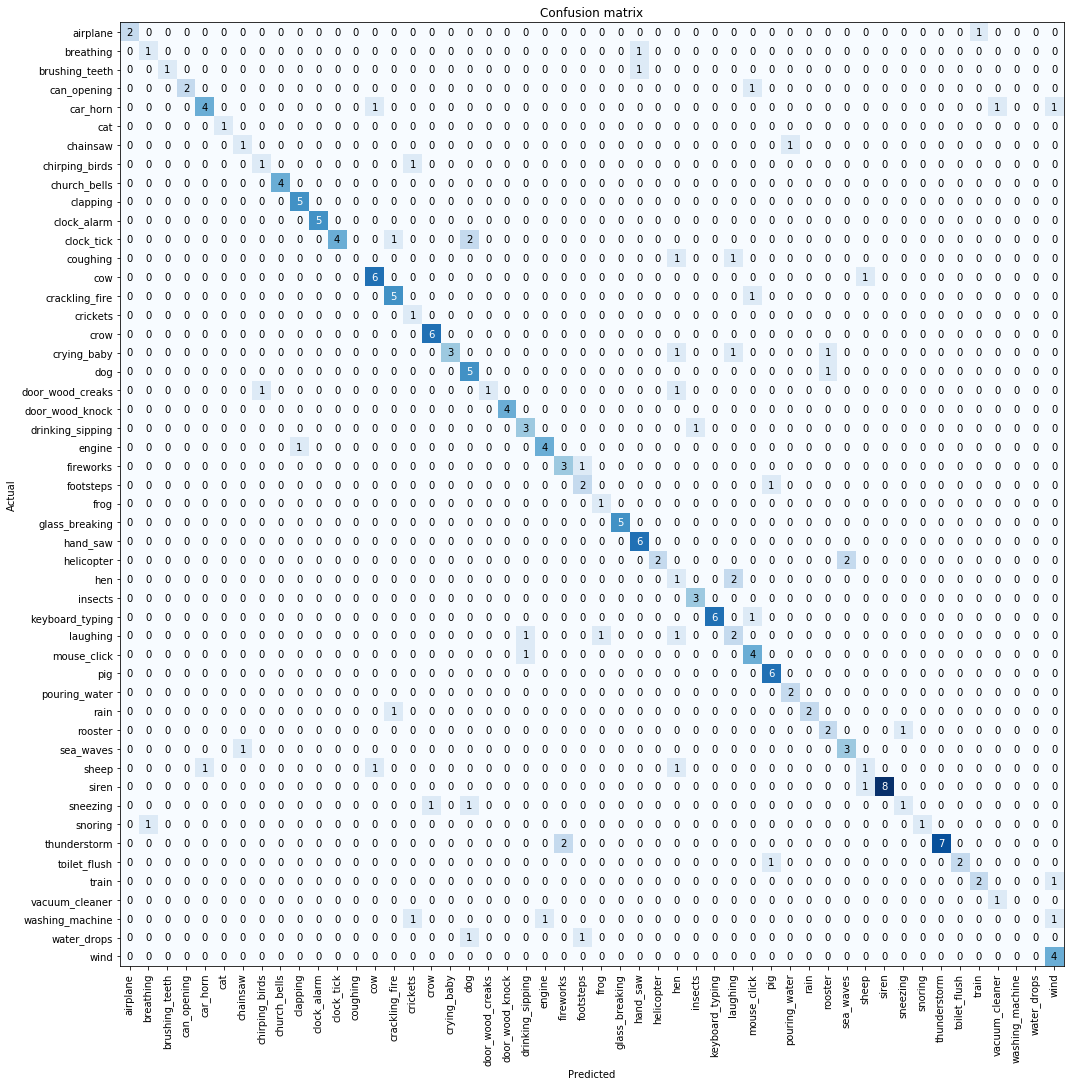

In [24]:
interp.plot_confusion_matrix(figsize=(15,15))

In [25]:
interp.most_confused(min_val=2)

[('clock_tick', 'dog', 2),
 ('helicopter', 'sea_waves', 2),
 ('hen', 'laughing', 2),
 ('thunderstorm', 'fireworks', 2)]

In [ ]:
#(plt.plot(sound)) may be work 